# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Batch Inference with Lagged PM2.5</span>

##  This notebook is divided into the following sections:

1. Download model
2. Get weather forecast and recent PM2.5 data
3. Make iterative predictions for next 7 days
4. Visualize predictions

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: C:\Users\leoli\Lab1ScalableMLDL
HopsworksSettings initialized!


## <span style='color:#ff5f27'>  Imports

In [2]:
import datetime
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import hopsworks
import json
import matplotlib.pyplot as plt
import os

In [3]:
today = datetime.datetime.now()
today

datetime.datetime(2025, 11, 18, 10, 3, 7, 157104)

## <span style="color:#ff5f27;">  Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 10:03:07,222 INFO: Initializing external client
2025-11-18 10:03:07,224 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 10:03:07,991 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 10:03:09,380 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286319


## <span style="color:#ff5f27;"> Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_lagged",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Downloading: 0.000%|          | 0/5917222 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/5917222 elapsed<00:00 remaining<?

In [6]:
# Load the XGBoost model
retrieved_xgboost_model = XGBRegressor()
retrieved_xgboost_model.load_model(saved_model_dir + "/xgboost_model_lagged_pm25.json")
retrieved_xgboost_model

XGBRegressor(base_score='2.650138E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;"> Get Weather Forecast and Recent PM2.5 Data </span>

In [7]:
# Get weather forecast for next 7 days
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values('date').head(7)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-19 00:00:00+00:00,3.20,0.0,9.686609,318.012878,glasgow
3,2025-11-20 00:00:00+00:00,3.95,0.0,10.495713,329.036316,glasgow
4,2025-11-21 00:00:00+00:00,5.35,0.0,19.242327,197.418060,glasgow
2,2025-11-22 00:00:00+00:00,6.00,0.4,26.319420,130.006195,glasgow
1,2025-11-23 00:00:00+00:00,6.85,0.1,9.178235,228.179916,glasgow


In [8]:
# Get recent PM2.5 data (last 3 days)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

# Get the most recent PM2.5 values
recent_pm25 = air_quality_fg.read()
recent_pm25 = recent_pm25.sort_values('date').tail(3)

print("Most recent PM2.5 values:")
print(recent_pm25[['date', 'pm25']])

# Extract the last 3 PM2.5 values for lagged features
pm25_values = recent_pm25['pm25'].values
print(f"\nLagged PM2.5 values to start predictions:")
print(f"  pm25_lag3 (3 days ago): {pm25_values[0]:.2f}")
print(f"  pm25_lag2 (2 days ago): {pm25_values[1]:.2f}")
print(f"  pm25_lag1 (yesterday): {pm25_values[2]:.2f}")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 
Most recent PM2.5 values:
                          date  pm25
2988 2025-11-07 00:00:00+00:00   1.0
2316 2025-11-08 00:00:00+00:00   1.0
3813 2025-11-17 00:00:00+00:00  30.0

Lagged PM2.5 values to start predictions:
  pm25_lag3 (3 days ago): 1.00
  pm25_lag2 (2 days ago): 1.00
  pm25_lag1 (yesterday): 30.00


### <span style="color:#ff5f27;"> Making the predictions</span>

We'll make predictions iteratively, using each predicted PM2.5 value as a feature for the next day's prediction.

In [9]:
# Identify weather feature columns
weather_cols = [col for col in batch_data.columns if any(pattern in col for pattern in 
                ['temperature', 'precipitation', 'wind_speed', 'wind_direction'])]
print(f"Weather feature columns: {weather_cols}")

Weather feature columns: ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']


In [10]:
# Initialize lagged values with most recent PM2.5 data
lagged_pm25 = list(pm25_values)  # [lag3, lag2, lag1]

predictions = []

# Make predictions for each day
for i in range(len(batch_data)):
    # Get weather features for this day
    weather_features = batch_data.iloc[i][weather_cols].values
    
    # Combine weather features with lagged PM2.5
    features = np.concatenate([
        weather_features,
        [lagged_pm25[-1], lagged_pm25[-2], lagged_pm25[-3]]  # lag1, lag2, lag3
    ])
    
    # Make prediction
    prediction = retrieved_xgboost_model.predict([features])[0]
    predictions.append(prediction)
    
    print(f"Day {i+1}: PM2.5 = {prediction:.2f} (using lags: {lagged_pm25[-1]:.2f}, {lagged_pm25[-2]:.2f}, {lagged_pm25[-3]:.2f})")
    
    # Update lagged values for next iteration
    lagged_pm25.append(prediction)
    lagged_pm25.pop(0)  # Remove oldest

# Add predictions to batch_data
batch_data['predicted_pm25'] = predictions
batch_data

Day 1: PM2.5 = 35.84 (using lags: 30.00, 1.00, 1.00)
Day 2: PM2.5 = 27.25 (using lags: 35.84, 30.00, 1.00)
Day 3: PM2.5 = 34.58 (using lags: 27.25, 35.84, 30.00)
Day 4: PM2.5 = 32.41 (using lags: 34.58, 27.25, 35.84)
Day 5: PM2.5 = 40.76 (using lags: 32.41, 34.58, 27.25)


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-19 00:00:00+00:00,3.20,0.0,9.686609,318.012878,glasgow,35.842033
3,2025-11-20 00:00:00+00:00,3.95,0.0,10.495713,329.036316,glasgow,27.251347
4,2025-11-21 00:00:00+00:00,5.35,0.0,19.242327,197.418060,glasgow,34.584080
2,2025-11-22 00:00:00+00:00,6.00,0.4,26.319420,130.006195,glasgow,32.414505
1,2025-11-23 00:00:00+00:00,6.85,0.1,9.178235,228.179916,glasgow,40.757469


## <span style="color:#ff5f27;"> Visualize Predictions</span>

2025-11-18 10:03:22,155 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


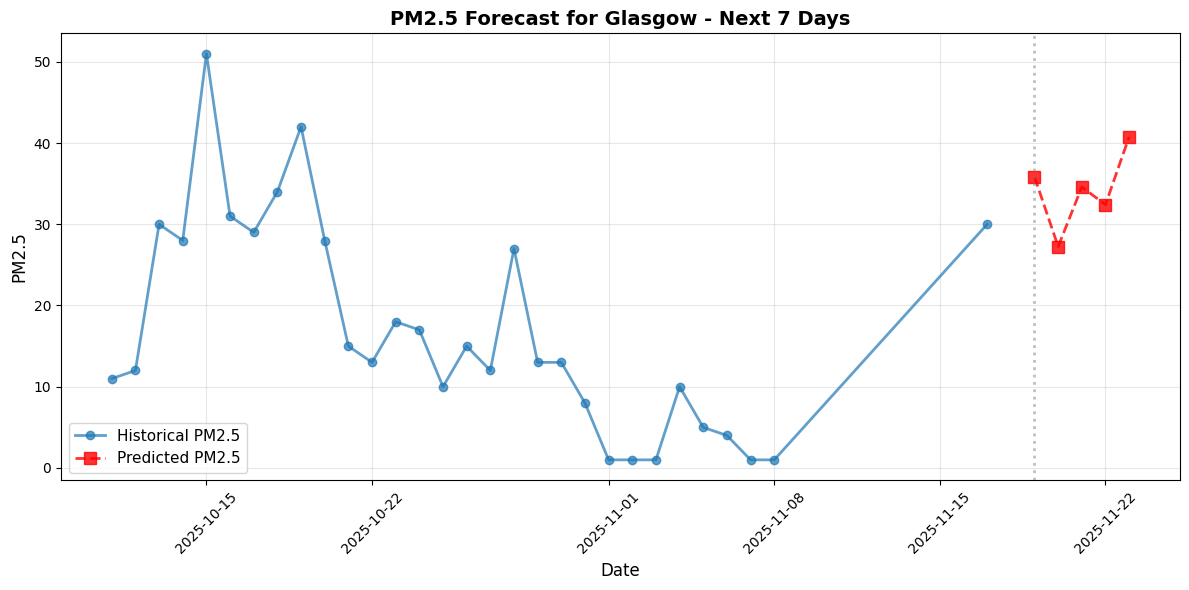


✓ Forecast plot saved to: /mnt/user-data/outputs/pm25_forecast_lagged.png


In [11]:
# Plot predictions
fig, ax = plt.subplots(figsize=(12, 6))

# Plot historical PM2.5
historical_data = air_quality_fg.read().sort_values('date').tail(30)
ax.plot(historical_data['date'], historical_data['pm25'], 
        marker='o', label='Historical PM2.5', linewidth=2, alpha=0.7)

# Plot predictions
ax.plot(batch_data['date'], batch_data['predicted_pm25'], 
        marker='s', label='Predicted PM2.5', linewidth=2, 
        linestyle='--', color='red', markersize=8, alpha=0.8)

# Add vertical line at forecast start
ax.axvline(x=batch_data['date'].iloc[0], color='gray', 
           linestyle=':', linewidth=2, alpha=0.5)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('PM2.5', fontsize=12)
ax.set_title(f'PM2.5 Forecast for {city.title()} - Next 7 Days', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('pm25_forecast_lagged.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Forecast plot saved to: /mnt/user-data/outputs/pm25_forecast_lagged.png")

In [12]:
# Save predictions
output_path = 'pm25_predictions_lagged.csv'
batch_data.to_csv(output_path, index=False)
print(f"✓ Predictions saved to: {output_path}")

# Display summary
print("\n" + "="*50)
print("FORECAST SUMMARY")
print("="*50)
print(f"Average PM2.5: {batch_data['predicted_pm25'].mean():.2f}")
print(f"Min PM2.5: {batch_data['predicted_pm25'].min():.2f}")
print(f"Max PM2.5: {batch_data['predicted_pm25'].max():.2f}")
print("\nDaily Predictions:")
print(batch_data[['date', 'predicted_pm25']].to_string(index=False))

✓ Predictions saved to: pm25_predictions_lagged.csv

FORECAST SUMMARY
Average PM2.5: 34.17
Min PM2.5: 27.25
Max PM2.5: 40.76

Daily Predictions:
                     date  predicted_pm25
2025-11-19 00:00:00+00:00       35.842033
2025-11-20 00:00:00+00:00       27.251347
2025-11-21 00:00:00+00:00       34.584080
2025-11-22 00:00:00+00:00       32.414505
2025-11-23 00:00:00+00:00       40.757469
